In [1]:
# Run if working locally
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import sqlite3
from sqlite3 import Error
import pickle
import os, sys
import config

config.root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, config.root_path)

from src.dataset.dataset import RawData
from src.dataset.wikisection_preprocessing import (
    tokenize,
    clean_sentence,
    preprocess_text_segmentation,
    format_data_for_db_insertion,
)
from src.dataset.utils import truncate_by_token
from db.dbv2 import Table, AugmentedTable, TrainTestTable
import pprint


from utils.metrics import windowdiff, pk

from src.bertkeywords.src.similarities import Embedding, Similarities
from src.bertkeywords.src.keywords import Keywords
from src.encoders.coherence_v2 import Coherence
from src.dataset.utils import flatten, dedupe_list, truncate_string
from src.experimentation.coherence_v2 import SimpleExperiment, CoherenceExperiment

/Users/mac/miniforge3/envs/phd/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/mac/miniforge3/envs/phd/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
experimentation = SimpleExperiment()

# constants
NUM_SAMPLES = 1000
#         MODEL_STRING="bert-base-uncased",
#         MODEL_STRING="sentence-transformers/LaBSE",
MODEL_STRING = "roberta-base"
# MODEL_STRING = "sentence-transformers/all-MiniLM-L6-v2"
GRAPHS = True
METRICS_SUMMARY = False
PREDICTIONS_SUMMARY = True
BATCH_SIZE = 15

# ----------------------------------------------------

# city experiments
# w/o keywords (i.e., ablation true)
experimentation.queue_experiment(
    CoherenceExperiment(
        dataset_type="city",
        model_string=MODEL_STRING,
        max_words_per_step=4,
        start=10000,
        num_samples=NUM_SAMPLES,
        same_word_multiplier=2,
        no_same_word_penalty=2,
        kb_embeddings=True,
        coherence_dump_on_prediction=False,
        coherence_threshold=0.3,
        prediction_threshold=0.47,
        pruning=1,
        pruning_min=7,
        batch_size=BATCH_SIZE,
        print_metrics_summary=METRICS_SUMMARY,
        print_predictions_summary=PREDICTIONS_SUMMARY,
        show_graphs=GRAPHS,
        keyword_diversity=0.3,
        diverse_keywords=False,
        similar_keywords=True,
        ablation=True,
    )
)
# # w/ keywords w/o sentence collation
# experimentation.queue_experiment(
#     CoherenceExperiment(
#         dataset_type="city",
#         model_string=MODEL_STRING,
#         max_words_per_step=4,
#         start=10000,
#         num_samples=NUM_SAMPLES,
#         same_word_multiplier=2,
#         no_same_word_penalty=2,
#         kb_embeddings=True,
#         coherence_dump_on_prediction=False,
#         coherence_threshold=0.3,
#         prediction_threshold=0.47,
#         pruning=1,
#         pruning_min=7,
#         batch_size=BATCH_SIZE,
#         print_metrics_summary=METRICS_SUMMARY,
#         print_predictions_summary=PREDICTIONS_SUMMARY,
#         show_graphs=GRAPHS,
#         keyword_diversity=0.3,
#         diverse_keywords=False,
#         similar_keywords=True,
#         ablation=False,
#     )
# )
# # w/ everything
# experimentation.queue_experiment(
#     CoherenceExperiment(
#         dataset_type="city",
#         model_string=MODEL_STRING,
#         max_words_per_step=8,
#         start=10000,
#         num_samples=NUM_SAMPLES,
#         same_word_multiplier=2,
#         no_same_word_penalty=2,
#         kb_embeddings=True,
#         coherence_dump_on_prediction=False,
#         coherence_threshold=0.3,
#         prediction_threshold=0.47,
#         pruning=1,
#         pruning_min=7,
#         batch_size=BATCH_SIZE,
#         print_metrics_summary=METRICS_SUMMARY,
#         print_predictions_summary=PREDICTIONS_SUMMARY,
#         show_graphs=GRAPHS,
#         keyword_diversity=0.3,
#         diverse_keywords=True,
#         similar_keywords=True,
#         ablation=False,
#     )
# )

# # disease experiments
# # w/o keywords (i.e., ablation true)
# experimentation.queue_experiment(
#     CoherenceExperiment(
#         dataset_type="disease",
#         model_string=MODEL_STRING,
#         max_words_per_step=4,
#         start=15000,
#         num_samples=NUM_SAMPLES,
#         same_word_multiplier=2,
#         no_same_word_penalty=2,
#         kb_embeddings=True,
#         coherence_dump_on_prediction=False,
#         coherence_threshold=0.3,
#         prediction_threshold=0.47,
#         pruning=1,
#         pruning_min=7,
#         batch_size=BATCH_SIZE,
#         print_metrics_summary=METRICS_SUMMARY,
#         print_predictions_summary=PREDICTIONS_SUMMARY,
#         show_graphs=GRAPHS,
#         keyword_diversity=0.3,
#         diverse_keywords=False,
#         similar_keywords=True,
#         ablation=True,
#     )
# )
# # w/ keywords w/o sentence collation
# experimentation.queue_experiment(
#     CoherenceExperiment(
#         dataset_type="disease",
#         model_string=MODEL_STRING,
#         max_words_per_step=4,
#         start=15000,
#         num_samples=NUM_SAMPLES,
#         same_word_multiplier=2,
#         no_same_word_penalty=2,
#         kb_embeddings=True,
#         coherence_dump_on_prediction=False,
#         coherence_threshold=0.3,
#         prediction_threshold=0.47,
#         pruning=1,
#         pruning_min=7,
#         batch_size=BATCH_SIZE,
#         print_metrics_summary=METRICS_SUMMARY,
#         print_predictions_summary=PREDICTIONS_SUMMARY,
#         show_graphs=GRAPHS,
#         keyword_diversity=0.3,
#         diverse_keywords=False,
#         similar_keywords=True,
#         ablation=False,
#     )
# )
# # w/ everything
# experimentation.queue_experiment(
#     CoherenceExperiment(
#         dataset_type="disease",
#         model_string=MODEL_STRING,
#         max_words_per_step=8,
#         start=10000,
#         num_samples=NUM_SAMPLES,
#         same_word_multiplier=2,
#         no_same_word_penalty=2,
#         kb_embeddings=True,
#         coherence_dump_on_prediction=False,
#         coherence_threshold=0.3,
#         prediction_threshold=0.47,
#         pruning=1,
#         pruning_min=7,
#         batch_size=BATCH_SIZE,
#         print_metrics_summary=METRICS_SUMMARY,
#         print_predictions_summary=PREDICTIONS_SUMMARY,
#         show_graphs=GRAPHS,
#         keyword_diversity=0.3,
#         diverse_keywords=True,
#         similar_keywords=True,
#         ablation=False,
#     )
# )

Running experiment set: isQih
Running experiment: CoherenceExperiment(num_samples=1000, start=10000, dataset_type='city', model_string='roberta-base', max_words_per_step=4, same_word_multiplier=2, no_same_word_penalty=2, prediction_threshold=0.47, coherence_threshold=0.3, coherence_dump_on_prediction=False, pruning=1, pruning_min=7, dynamic_threshold=False, threshold_warmup=10, last_n_threshold=5, kb_embeddings=True, experiment_hash='htZxe', batch_size=15, keyword_diversity=0.3, diverse_keywords=False, similar_keywords=True, ablation=True, print_metrics_summary=False, print_predictions_summary=True, show_graphs=True)
Using dataset: wikisection_city


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/491 [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

(…)kage/Data/com.apple.CoreML/model.mlmodel:   0%|          | 0.00/165k [00:00<?, ?B/s]

weight.bin:   0%|          | 0.00/532M [00:00<?, ?B/s]

(…)sk/float32_model.mlpackage/Manifest.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/532M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/Users/mac/miniforge3/envs/phd/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


TOTAL BATCHES: 66

.............. 1 ............... 2 ............... 3 ............... 4 ............... 5 ............... 6 ............... 7 ............... 8 ............... 9 ............... 10 ............... 11 ............... 12 ............... 13 ............... 14 ............... 15 ............... 16 ............... 17 ............... 18 ............... 19 ............... 20 ............... 21 ............... 22 ............... 23 ............... 24 ............... 25 ............... 26 ............... 27 ............... 28 ............... 29 ............... 30 ............... 31 ............... 32 ............... 33 ............... 34 ............... 35 ............... 36 ............... 37 ............... 38 ............... 39 ............... 40 ............... 41 ............... 42 ............... 43 ............... 44 ............... 45 ............... 46 ............... 47 ............... 48 ............... 49 ............... 50 ............... 51 ............... 52 ...

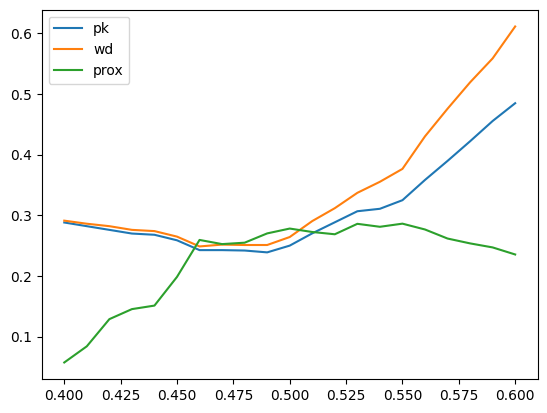

============= Predictions Summary =============
best pk: 0.2387858347386172, best prediction threshold: 0.49, proximity: 0.27004599370612437
P:[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [4]:
experimentation.run()

### =========================================================

### Testing proximity metrics

In [71]:
# fmt: off
predictions=[1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
real=[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
# fmt: on

<IPython.core.display.Javascript object>

In [72]:
def check_proximity(predictions, real, proximity=2):
    exact_matches = 0
    very_close_matches = 0  # within 1 step
    close_matches = 0  # within 2 steps

    for i, (p, r) in enumerate(zip(predictions, real)):
        # take care of all the cases where we're at the
        # beginning of the arrays
        prev_idx = i - 1
        prev_prev_idx = i - 2
        if i == 0 or i == 1:
            prev_idx = 0
            prev_prev_idx = 0

        prev_prediction = predictions[prev_idx]
        prev_prev_prediction = predictions[prev_prev_idx]

        # take care of all the cases where we're at the
        # end of the arrays
        next_idx = i + 1
        next_next_idx = i + 2
        if i == (len(predictions) - 1):
            next_idx = i
            next_next_idx = i
        if i == (len(predictions) - 2):
            next_idx = i + 1
            next_next_idx = i + 1

        next_prediction = predictions[next_idx]
        next_next_prediction = predictions[next_next_idx]

        if r == 1 and p == 1:
            exact_matches += 1
            continue
        if r == 1:
            if prev_prediction == 1 or next_prediction == 1:
                very_close_matches += 1
                continue
            if prev_prev_prediction == 1 or next_next_prediction == 1:
                close_matches += 1
                continue
            continue

    return exact_matches, very_close_matches, close_matches

<IPython.core.display.Javascript object>

In [73]:
exact_matches, close_matches, very_close_matches = check_proximity(predictions, real)

<IPython.core.display.Javascript object>

In [74]:
exact_matches, close_matches, very_close_matches, predictions.count(1), real.count(1)

(11, 0, 1, 15, 39)

<IPython.core.display.Javascript object>

In [75]:
num_positive_predictions = predictions.count(1)
num_real_positives = real.count(1)

<IPython.core.display.Javascript object>

In [76]:
print("Predictions ----->")
print(
    f"Percentage of positive predictions made that are within proximity of 2: {100*close_matches/num_positive_predictions}"
)
print(
    f"Percentage of positive predictions made that are within proximity of 1: {100*very_close_matches/num_positive_predictions}"
)
print(
    f"Percentage of positive predictions made that are exact matches: {100*exact_matches/num_positive_predictions}"
)
print("Real ----->")
print(
    f"Percentage of real predictions made that are within proximity of 2: {100*close_matches/num_real_positives}"
)
print(
    f"Percentage of real predictions made that are within proximity of 1: {100*very_close_matches/num_real_positives}"
)
print(
    f"Percentage of real predictions made that are exact matches: {100*exact_matches/num_real_positives}"
)

Predictions ----->
Percentage of positive predictions made that are within proximity of 2: 0.0
Percentage of positive predictions made that are within proximity of 1: 6.666666666666667
Percentage of positive predictions made that are exact matches: 73.33333333333333
Real ----->
Percentage of positive predictions made that are within proximity of 2: 0.0
Percentage of positive predictions made that are within proximity of 1: 2.5641025641025643
Percentage of positive predictions made that are exact matches: 28.205128205128204


<IPython.core.display.Javascript object>

In [82]:
proximity = (
    (1 / 3 * (close_matches / num_real_positives))
    + (1 / 2 * (very_close_matches / num_real_positives))
    + (exact_matches / num_real_positives)
) / (
    (1 / 3 * (close_matches / num_positive_predictions))
    + (1 / 2 * (very_close_matches / num_positive_predictions))
    + (exact_matches / num_positive_predictions)
)

<IPython.core.display.Javascript object>

In [84]:
proximity

0.38461538461538464

<IPython.core.display.Javascript object>

In [90]:
numerator = (
    (1 / 3 * (close_matches / num_real_positives))
    + (1 / 2 * (very_close_matches / num_real_positives))
    + (exact_matches / num_real_positives)
)

denominator = (
    (1 / 3 * (close_matches / num_positive_predictions))
    + (1 / 2 * (very_close_matches / num_positive_predictions))
    + (exact_matches / num_positive_predictions)
)

num_real_positives, num_positive_predictions, numerator, denominator

(39, 15, 0.2948717948717949, 0.7666666666666666)

<IPython.core.display.Javascript object>

In [92]:
numerator * denominator, denominator / numerator

(0.22606837606837607, 2.5999999999999996)

<IPython.core.display.Javascript object>